In [ ]:
#| hide
#| default_exp planner
from nbdev import *

# Temperature scan planner

In [ ]:
#| export
from ase.build import bulk
import ase.units as un
import asap3
from hecss.util import HECSS_Sampler 
from hecss.util import select_asap_model
from hecss.monitor import plot_stats
from scipy import stats
from matplotlib import pylab as plt
import numpy as np
from tqdm.auto import tqdm

In [ ]:
#| export
def plan_T_scan(Tlo, Thi, nat, N=1, plot_dist=True):
    l = Tlo
    n = np.sqrt(3*nat/2)
    s0 = l/n
    s = s0
    assert n>1
    a = (n+1)/(n-1)
    r = []
    while l <= Thi:
        sf = s 
        if l * a > Thi:
            sf *= 1.12
        
        r.append([l, s, sf/s0])
        l *= a
        s = l/n
    ns = 1
    frm = "N=%.1f"
    if N > 1 :
        ns = N/r[-1][-1]
        frm = "N=%.0f"
        r = [[l, s, int(round(ns*sf))] for l, s, sf in r]
    frm = frm + " T=%.0fK"
    if plot_dist:
        f = stats.norm.pdf
        x = np.linspace(Tlo*(1-3/n), Thi*(1+3/n), 600)
        y = np.zeros(x.shape)
        for c, (l, s, sf) in enumerate(r):
            p = sf*f(x, l, s)
            # plt.axvline(l-l/n, ymax=0.5, lw=1, ls='-', color=f'C{c}')
            # plt.axvline(l+l/n, ymin=0.5, lw=1, ls='-', color=f'C{c}')
            plt.plot(x, p, label=(frm % (sf, l))) #f'N={sf*ns:.1f} T={l:.0f}K'
            y += p
        plt.plot(x, y)
        plt.legend(loc='upper right')
        plt.xlabel('Temperature')
        plt.ylabel('Relative density')
        plt.title('Temperature scan. N=relative number of samples')
    return r

## Simulate with `stats.normal` random variable

  0%|          | 0/6 [00:00<?, ?it/s]

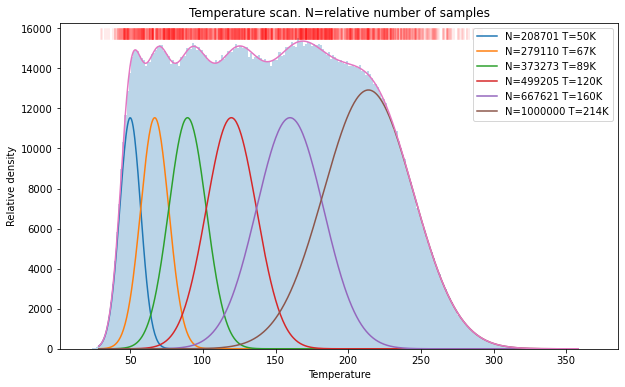

In [ ]:
# semilogx()
plt.figure(figsize=(10,6))
rv = stats.norm
N = 1_000_000
plan = plan_T_scan(50, 250, 32, N)

el = np.zeros(0)
for c, (l, s, n) in enumerate(tqdm(plan)):
    el = np.append(el, rv.rvs(loc=l, scale=s, size=n))

skip = len(el)//2000
skip = int(max(1, skip))
for s in el[::skip]:
    plt.axvline(s, ymin=0.95, ymax=0.98, ls='-', color='r', alpha=0.1)
    
NF = sum([sf for _, _, sf in plan])
counts, bins = np.histogram(el, bins='auto', density=True)
plt.hist(bins[:-1], bins, weights=NF*counts, color='C0', alpha=0.3);

## Simulate with `HECSS_Sampler` generator

In [ ]:
#| asap
model = select_asap_model('SiC')
print(f'Using potential model: {model}')

sys_size = '3x3x3'
sc = [int(v) for v in sys_size.split('x')]

cryst = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
cryst.set_calculator(asap3.OpenKIMcalculator(model))

Using potential model: MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000


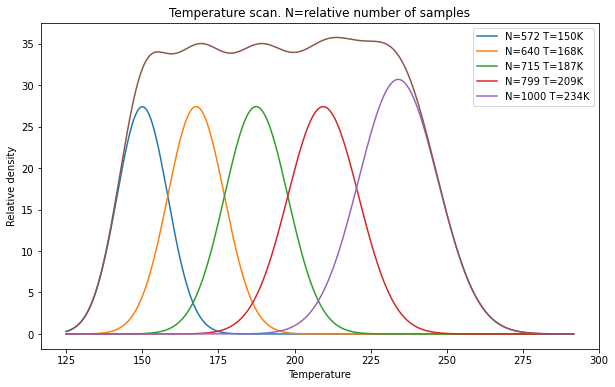

In [ ]:
#| asap
N = 1_000
plt.figure(figsize=(10,6))
plan = plan_T_scan(150, 250, len(cryst), N)

In [ ]:
#| asap
smpls = []
for T, sig, n in tqdm(plan):
    sampler = HECSS_Sampler(cryst, asap3.OpenKIMcalculator(model),
                            T, N=int(n), pbar=tqdm(total=n))
    smpls.append([s for s in sampler])
ell = [[s[-1] for s in sl] for sl in smpls]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/715 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.015, 0.045)

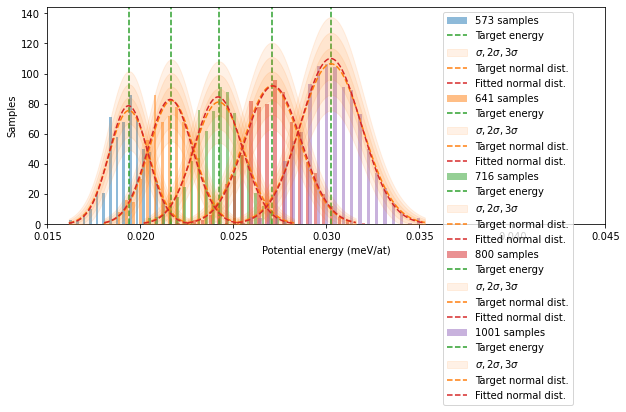

In [ ]:
#| asap
plt.figure(figsize=(10,4))
for s, (T, sig, n) in zip(smpls, plan):
    plot_stats(s, T, show=False)
plt.xlim(0.015, 0.045)

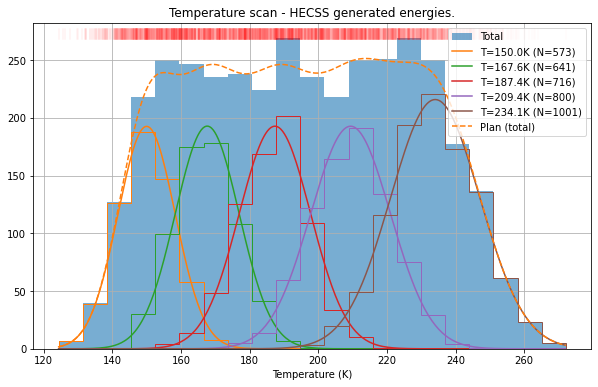

In [ ]:
#| asap
plt.figure(figsize=(10,6))
if N < 1_000:
    bins = np.linspace(min(flatten(ell)), max(flatten(ell)), 40)*2/un.kB/3
else :
    bins = 'auto'
cnt, bins, _ = plt.hist(np.array(list(flatten(ell)))*2/un.kB/3, 
                     bins=bins, density=False, alpha=0.6, label='Total');
x = np.linspace(bins[0], bins[-1], 300)
y = np.zeros(x.shape)
tdx = bins[1]-bins[0]
for c, (el, (T, sig, n)) in enumerate(zip(ell, plan)):
    e = np.array(el)
    # bins = 'auto'
    Tc, Tb, _ = plt.hist(e*2/un.kB/3, bins=bins, density=False, 
                         histtype='step', color=f'C{c+1}');
    dx = Tb[1]-Tb[0]
    plt.plot(x, dx*n*stats.norm.pdf(x, loc=T, scale=sig), color=f'C{c+1}', 
             label=f'{T=:.1f}K (N={int(Tc.sum())})')
    y += tdx*n*stats.norm.pdf(x, loc=T, scale=sig)

    skip = len(el)//500
    skip = max(1, skip)
    for v in e[::skip]*2/un.kB/3:
        plt.axvline(v, ymin=0.95, ymax=0.98, ls='-', color='r', alpha=0.05)
    
plt.plot(x, y, '--', label='Plan (total)')
plt.xlabel('Temperature (K)')
plt.legend(loc='upper right')
plt.title('Temperature scan - HECSS generated energies.')
plt.grid()
plt.savefig(f'T_scan_{N=}.pdf')